In [1]:
import os
import shutil
import cv2
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow.python.framework.ops import get_resource_handle_data

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4793253651090034762
 xla_global_id: -1]

In [2]:
metadata = pd.read_csv("./data/HAM10000_metadata.csv")
metadata.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [8]:
diagnosis_type = metadata.dx.unique()
data_path = "./data/images"
for type in diagnosis_type:
    path = os.path.join(data_path,type)
    os.mkdir(path)
os.listdir("./data/")

['HAM10000_images_part_1',
 'HAM10000_images_part_2',
 'HAM10000_metadata.csv',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_L.csv',
 'hmnist_8_8_RGB.csv',
 'images']

In [3]:
diagnose = metadata.loc[metadata["image_id"] == "ISIC_0027419"]["dx"].values[0]
diagnose

'bkl'

In [4]:
os.listdir("./data/HAM10000_images_part_1/")[0][:-4]


'ISIC_0024306'

In [31]:
image_list = os.listdir("./data/HAM10000_images_part_2/")
for image in tqdm(image_list):
    shutil.copy(f"./data/HAM10000_images_part_2/{image}",f'./data/images/{metadata.loc[metadata["image_id"] == image[:-4]]["dx"].values[0]}')

100%|██████████| 5015/5015 [00:47<00:00, 105.54it/s]


In [41]:
!pip install tf-nightly

In [5]:
image_data = tf.keras.preprocessing.image_dataset_from_directory("./data/images/")

Found 10015 files belonging to 7 classes.


In [12]:
tf.keras.preprocessing.image_dataset_from_directory??

Signature:
tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
)
Source:   
@keras_export(
    "keras.utils.image_dataset_from_directory",
    "keras.preprocessing.image_dataset_from_directory",
    v1=[],
)
def image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
):
    """Generates a `tf.data.Dataset` from image files in a directory.

    If your directory structu

In [6]:
image_data_iterator = image_data.as_numpy_iterator()
image_data_iterator
batch = image_data_iterator.next()


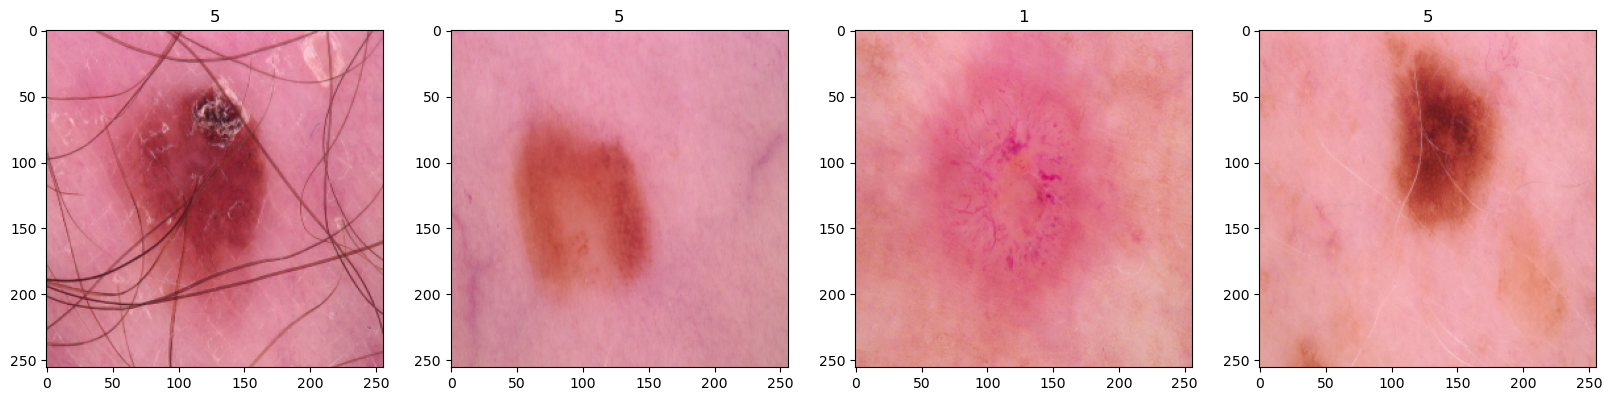

In [7]:
from matplotlib import pyplot as plt
fig,ax = plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])



In [8]:
batch[0].max()/255

0.9929579790900736

In [9]:
scaled_image_data = image_data.map(lambda x,y:(x/255,y))

In [10]:
train_size = int(len(scaled_image_data)*0.7)
validation_size = int(len(scaled_image_data)*0.2)
test_size = int(len(scaled_image_data)*0.1)
train_size,validation_size,test_size

(219, 62, 31)

In [11]:
train = scaled_image_data.take(train_size)
validation = scaled_image_data.skip(train_size).take(validation_size)
test = scaled_image_data.skip(train_size+validation_size).take(test_size)

In [12]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [14]:
model = Sequential()

In [15]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [16]:
model.compile('adam', loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [20]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices()))

Num GPUs Available:  1


In [21]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17075638169748122562
xla_global_id: -1
]


In [39]:
logdir = "logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train, epochs=20, validation_data=validation, callbacks=[tensorboard_callback])

Epoch 1/20
219/219 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0501

KeyboardInterrupt: 